In [1]:
# stacked generalization with linear meta model on blobs dataset
import tensorflow as tf

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import sklearn.linear_model as lm
logreg = lm.LogisticRegression(multi_class='multinomial', solver='lbfgs')
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from numpy import dstack

import os
from functools import partial
from collections import namedtuple
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD

In [2]:
INPUT_ROOT = '/kaggle/input/lung-and-colon-cancer-histopathological-images'
DATA_DIR = os.path.join(INPUT_ROOT, 'lung_colon_image_set', 'lung_image_sets')

In [3]:
data = image.ImageDataGenerator(validation_split = 0.2)
BATCH_SIZE = 15
# Change batch size, if you run out of memory!
# Or increase it, if you have a lot of RAM (>> 16 Gb) for faster trainig
IMG_SHAPE = (256, 256, 3)

In [4]:
generate_data = partial(
    data.flow_from_directory,
    DATA_DIR,
    class_mode = 'categorical',
    color_mode = 'rgb',
    target_size = IMG_SHAPE[:2],
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = 666
)

print('Trainig data:')
train_iter = generate_data(subset='training')
print('Validating data:')
validate_iter = generate_data(subset='validation')

Trainig data:
Found 12000 images belonging to 3 classes.
Validating data:
Found 3000 images belonging to 3 classes.


In [5]:
all_models = list()

filename = '../input/finalized-model2/EfficientNetB7finalized_model.h5'
model = load_model(filename)
all_models.append(model)

filename = '../input/finalized-model2/ResNet152finalized_model.h5'
model = load_model(filename)
all_models.append(model)

filename = '../input/finalized-model2/ResNet50finalized_model.h5'
model = load_model(filename)
all_models.append(model)

filename = '../input/finalized-model2/VGG16finalized_model.h5'
model = load_model(filename)
all_models.append(model)

filename = '../input/finalized-model2/VGG16finalized_model.h5'
model = load_model(filename)
all_models.append(model)


'''
filename = '../input/finalized-model2/ResNet101finalized_model.h5'
model = load_model(filename)
all_models.append(model)

#filename = '../input/finalized-model2/ResNet152finalized_model.h5'
#model = load_model(filename)
#all_models.append(model)

filename = '../input/finalized-model2/ResNet50finalized_model.h5'
model = load_model(filename)
all_models.append(model)

filename = '../input/finalized-model2/VGG16finalized_model.h5'
model = load_model(filename)
all_models.append(model)
'''

    

2022-06-18 16:48:17.545963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 16:48:17.656824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 16:48:17.657763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 16:48:17.659091: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

"\nfilename = '../input/finalized-model2/ResNet101finalized_model.h5'\nmodel = load_model(filename)\nall_models.append(model)\n\n#filename = '../input/finalized-model2/ResNet152finalized_model.h5'\n#model = load_model(filename)\n#all_models.append(model)\n\nfilename = '../input/finalized-model2/ResNet50finalized_model.h5'\nmodel = load_model(filename)\nall_models.append(model)\n\nfilename = '../input/finalized-model2/VGG16finalized_model.h5'\nmodel = load_model(filename)\nall_models.append(model)\n"

In [6]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(member,inputX):
    three = []
    #three_k = []
    stackX = []
    '''
    for i in range(len(inputX)):
        # make prediction
        #c=0
        for i in range(len(members)):
            new_image = load_image(inputX[i])
            yhat = members[i].predict(new_image, verbose=0)
            # stack predictions into [rows, members, probabilities]
            three.append(yhat[0])
            
            if stackX is None:
                stackX = yhat
            else:
                stackX = dstack((stackX, yhat))
            
        stackX.append(three)
    '''
    for i in range(len(inputX)):
        new_image = load_image(inputX[i])
        yhat = member.predict(new_image, verbose=0)
        three.append(yhat[0])
    
    stackX.append(three)
            
    # flatten predictions to [rows, members x probabilities]
    stackX = np.array(stackX)
    #print(stackX.shape[0])
    #print(stackX.shape[1])
    #print(stackX.shape[2])
    print(stackX)
    print(len(stackX))
    print(stackX.shape)
    #stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

In [7]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy, data):
    # create dataset using ensemble
    #stackedX = stacked_dataset(members, inputX)
    stackedX = data
    # fit standalone model
    model = logreg
    inputy = np.array(inputy)
    #inputy = inputy.reshape(3000,1)
    model.fit(stackedX, inputy)
    return model

In [8]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX, data):
    # create dataset using ensemble
    #stackedX = stacked_dataset(members, inputX)
    stackedX = data
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [9]:
'''
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
'''

'''
# evaluate standalone models on test dataset
for model in members:
	testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)
'''

"\n# evaluate standalone models on test dataset\nfor model in members:\n\ttesty_enc = to_categorical(testy)\n\t_, acc = model.evaluate(testX, testy_enc, verbose=0)\n\tprint('Model Accuracy: %.3f' % acc)\n"

In [10]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
from keras import models


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(256, 256,3))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    #img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
  
    return img_tensor


In [11]:
# import required module
import os
import pandas as pd
# assign directory

path_list = list()
y_list = list()
directory1 = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca'
directory2 = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n'
directory3 = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc'
# iterate over files in
# that directory

for filename in os.listdir(directory1):
    f = os.path.join(directory1, filename)
    #new_image = load_image(f)
    path_list.append(f)
    y_list.append(-1) #lung aca

# iterate over files in
# that directory

for filename in os.listdir(directory2):
    f = os.path.join(directory2, filename)
    #new_image = load_image(f)
    path_list.append(f)
    y_list.append(0) #lung n
        

# iterate over files in
# that directory

for filename in os.listdir(directory3):
    f = os.path.join(directory3, filename)
    #new_image = load_image(f)
    path_list.append(f)
    y_list.append(1) #lung scc


input_data = pd.DataFrame(list(zip(path_list,y_list)),columns =['Path', 'Class'])
input_data = input_data.sample(frac = 1)
input_data.head()

,Path,Class
2521,../input/lung-and-colon-cancer-histopathologic...,-1
7777,../input/lung-and-colon-cancer-histopathologic...,0
5736,../input/lung-and-colon-cancer-histopathologic...,0
7167,../input/lung-and-colon-cancer-histopathologic...,0
8241,../input/lung-and-colon-cancer-histopathologic...,0


In [12]:
input_data.to_csv('test.csv')

In [13]:
from sklearn.model_selection import train_test_split

input_data = pd.read_csv('./test.csv')

train, test = train_test_split(input_data, test_size=0.2)
print(train.shape)
print(test.shape)

(12000, 3)
(3000, 3)


In [14]:
input_data.head()

,Unnamed: 0,Path,Class
0,2521,../input/lung-and-colon-cancer-histopathologic...,-1
1,7777,../input/lung-and-colon-cancer-histopathologic...,0
2,5736,../input/lung-and-colon-cancer-histopathologic...,0
3,7167,../input/lung-and-colon-cancer-histopathologic...,0
4,8241,../input/lung-and-colon-cancer-histopathologic...,0


In [15]:
trainX, testX = list(train['Path']),list(test['Path'])
trainy, testy = list(train['Class']),list(test['Class'])

In [16]:
#members = load_all_models(n_members)
members = all_models
print('Loaded %d models' % len(members))

Loaded 5 models


In [17]:
m1=stacked_dataset(members[0], testX)
m2=stacked_dataset(members[1], testX)
m3=stacked_dataset(members[2], testX)
m4=stacked_dataset(members[3], testX)
m5=stacked_dataset(members[4], testX)
#m2=m1
#m3=m1
#m4=m1
#m5=m4
#t = m1

2022-06-18 16:48:43.218698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-18 16:48:48.420133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


[[[1.6903857e-06 2.0887697e-36 9.9999833e-01]
  [1.7481876e-09 1.0000000e+00 1.0192052e-24]
  [1.2141159e-05 9.9998784e-01 1.9781917e-12]
  ...
  [5.8765239e-03 2.1301301e-16 9.9412352e-01]
  [9.1068915e-07 9.9999905e-01 2.6175225e-18]
  [4.9706972e-10 1.0000000e+00 7.4073312e-26]]]
1
(1, 3000, 3)
[[[5.9377324e-13 2.9368399e-25 1.0000000e+00]
  [4.7624815e-21 1.0000000e+00 0.0000000e+00]
  [6.2816552e-33 1.0000000e+00 0.0000000e+00]
  ...
  [1.0000000e+00 2.8464712e-18 4.3664548e-11]
  [1.5236454e-35 1.0000000e+00 0.0000000e+00]
  [1.0902133e-28 1.0000000e+00 0.0000000e+00]]]
1
(1, 3000, 3)
[[[3.6261201e-06 9.3399188e-18 9.9999642e-01]
  [5.6042385e-28 1.0000000e+00 9.6556507e-31]
  [0.0000000e+00 1.0000000e+00 0.0000000e+00]
  ...
  [9.9999988e-01 1.1994069e-08 8.8839109e-08]
  [2.2212635e-31 1.0000000e+00 1.2413435e-30]
  [5.7586550e-26 1.0000000e+00 3.0473854e-31]]]
1
(1, 3000, 3)
[[[1.4683596e-11 9.6117684e-24 1.0000000e+00]
  [9.4940791e-36 1.0000000e+00 0.0000000e+00]
  [0.000000

In [18]:
m1 = m1[0]
m2 = m2[0]
m3 = m3[0]
m4 = m4[0]
m5 = m5[0]

In [19]:
#print(t.shape)

In [20]:
all_data = []
for i in range(3000):
    all_model = []
    all_model.append(m1[i])
    all_model.append(m2[i])
    all_model.append(m3[i])
    all_model.append(m4[i])
    all_model.append(m5[i])
    all_data.append(all_model)

In [21]:
all_data = np.array(all_data)
all_data = all_data.reshape(all_data.shape[0],(all_data.shape[1]*all_data.shape[2]))

In [22]:
all_data.shape

(3000, 15)

In [23]:
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy, all_data)

In [24]:
import pickle
#model.save('finalized_model.h5')
#model.save_weights('my_model_weights.h5')
pickle.dump(model, open('model.pkl', 'wb'))

In [40]:
# evaluate model on test set
yhat = stacked_prediction(members, model, testX, all_data)


In [67]:
print(yhat)
print(type(yhat))
print(yhat.shape)

[ 1  0  0 ... -1  0  0]
<class 'numpy.ndarray'>
(3000,)


In [29]:
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.10f' % acc)

Stacked Test Accuracy: 0.9996666667


In [30]:
print(all_models)

[<keras.engine.functional.Functional object at 0x7f30e57cddd0>, <keras.engine.functional.Functional object at 0x7f30cc554710>, <keras.engine.functional.Functional object at 0x7f30e4c47f90>, <keras.engine.functional.Functional object at 0x7f30c1bd12d0>, <keras.engine.functional.Functional object at 0x7f30e425a8d0>]


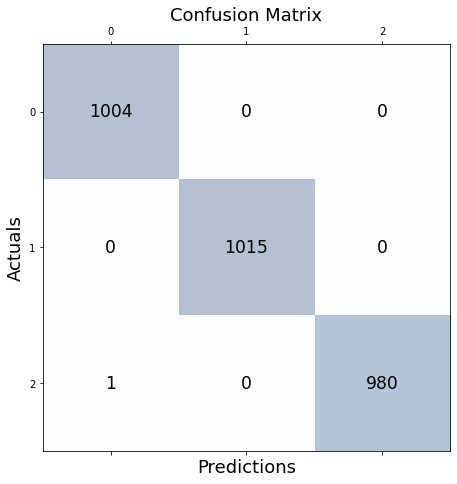

In [31]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=testy, y_pred=yhat)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig('conf_matrix.png',transparent=False)

In [33]:
plt.show()

In [34]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(testy,yhat,average='micro')

0.9996666666666667

In [35]:
recall_score(testy,yhat,average='micro')

0.9996666666666667

In [36]:
# To compute the F1 score, simply call the f1_score() function:
from sklearn.metrics import f1_score
f1_score(testy,yhat,average='micro')

0.9996666666666667

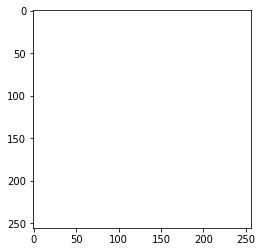

Tensor shape:
(5, 3)
[[9.4681674e-13 0.0000000e+00 1.0000000e+00]
 [4.8192147e-26 0.0000000e+00 1.0000000e+00]
 [1.7927279e-11 1.6610004e-29 1.0000000e+00]
 [7.7421074e-09 8.1864478e-26 1.0000000e+00]
 [7.7421074e-09 8.1864478e-26 1.0000000e+00]]
(1, 5, 3)
(1, 15)
Squamous cell carcinoma
[1]


In [159]:
# image path
img_path = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg'   # dog
#img_path = '/media/data/dogscats/test1/19.jpg'      # cat
#img_path1 = img_path+'lung_aca/lungaca10.jpeg'
#img_path2 = img_path+'lung_n/lungn1000.jpeg'
#img_path3 = img_path+'lung_scc/lungscc1.jpeg'

# load a single image
img = image.load_img(img_path, target_size=(256, 256,3))
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis=0)
#img_tensor /= 255


plt.imshow(img_tensor[0])                           
#plt.axis('off')
plt.show()


#img_tensor[0].shape



# check prediction
ypred = list()
for i in range(len(all_models)):
    pred = all_models[i].predict(img_tensor)
    ypred.append(pred[0])

ypred = np.array(ypred)

print("Tensor shape:")
print(ypred.shape)
print(ypred)


ypred = ypred.tolist()
k = []
k.append(ypred)
ypred = np.array(k)
print(ypred.shape)


ypred = ypred.reshape((ypred.shape[0],ypred.shape[1]*ypred.shape[2]))


#stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
print(ypred.shape)


y_predict = stacked_prediction(members, model, testX, ypred)

if(y_predict[0]==-1):
    print("Adenocarcinoma")
elif(y_predict[0]==0):
    print("Benign")
elif(y_predict[0]==1):
    print("Squamous cell carcinoma")
else:
    print("Invalid")
    
print(y_predict)

# Integrated Stacking Model

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
 

In [ ]:
# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = set(model.input for model in members)
    ensemble_visible.tolist()
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(3, activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # encode output data
    inputy_enc = to_categorical(inputy)
    # fit model
    model.fit(X, inputy_enc, epochs=300, verbose=0)

In [ ]:
 
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(X, verbose=0)

In [ ]:
members = all_models
stacked_model = define_stacked_model(members)
print(stacked_model)

In [ ]:
# fit stacked model on test dataset
fit_stacked_model(stacked_model, all_data, testy)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, all_data)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)